In [1]:
from composer.utils.object_store import ObjectStoreProviderHparams
from lth_diet.exps import LotteryExperiment
from lth_diet.utils import utils
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from tqdm import tqdm
plt.style.use("default")
rc = {"figure.figsize": (4, 3), "figure.dpi": 150, "figure.constrained_layout.use": True, "axes.grid": True, 
      "axes.spines.right": False, "axes.spines.top": False, "axes.linewidth": 0.6, "grid.linewidth": 0.6,
      "xtick.major.width": 0.6, "ytick.major.width": 0.6, "xtick.major.size": 4, "ytick.major.size": 4, 
      "axes.labelsize": 11, "axes.titlesize": 11, "xtick.labelsize": 10, "ytick.labelsize": 10,
      "axes.titlepad": 4, "axes.labelpad": 2, "xtick.major.pad": 2, "ytick.major.pad": 2,
      "lines.linewidth": 1.2, 'lines.markeredgecolor': 'w', "patch.linewidth": 0}
sns.set_theme(style='ticks', palette=sns.color_palette("tab10"), rc=rc)
object_store = ObjectStoreProviderHparams('google_storage', 'prunes', 'GCS_KEY').initialize_object()
bucket_dir = os.environ['OBJECT_STORE_DIR']

In [2]:
%config InlineBackend.figure_format = 'retina'

In [74]:
def get_accuracy_val(exp, num_reps, object_store, level):
    exp_hash = utils.get_hash(exp.name)
    num_reps_seen = 0
    steps_rt, accs_rt = [], []
    for rep in range(num_reps):
        if utils.object_exists_in_bucket(
            f"{bucket_dir}/{exp_hash}/replicate_{rep}/level_{level}/main/log.txt", object_store
        ):
            num_reps_seen += 1
            object_store.download_object(
                f"{bucket_dir}/{exp_hash}/replicate_{rep}/level_{level}/main/log.txt", "temp.txt"
            )
            log = pd.read_table("temp.txt", header=None)[0]
            os.remove("temp.txt")
            steps_t, accs_t = [], []
            for line in log:
                match = re.search('\[EPOCH\]\[step=(\d*)\]: { "accuracy/val": ([+-]?[0-9]*[.]?[0-9]+), \}', line)
                if match:
                    steps_t.append(int(match.group(1)))
                    accs_t.append(float(match.group(2)))
            steps_rt.append(steps_t)
            accs_rt.append(accs_t)
            if num_reps_seen == 4:
                break
    steps_rt, accs_rt = np.array(steps_rt), np.array(accs_rt)
    return steps_rt, accs_rt

In [4]:
config = f"../configs/lottery_cinic10.yaml"
num_replicates = 4
rewinding_steps = ["0ba", "200ba", "400ba", "800ba"]
num_levels = 12
exp = LotteryExperiment.create(f=config, cli_args=False)

In [5]:

accs__rew_lvl_rep = []
for rs in tqdm(rewinding_steps):
    accs__lvl_rep = []
    for lvl in range(num_levels+1):
        exp.pretrain_optimizer.lr = 0.1
        exp.rewinding_steps = rs
        _, accs_rt = get_accuracy_val(exp, num_replicates, object_store, lvl)
        accs__lvl_rep.append(accs_rt[:, -1])
    accs__rew_lvl_rep.append(accs__lvl_rep)

100%|██████████| 4/4 [03:12<00:00, 48.15s/it]


In [6]:
accs_baseline = np.array(accs__rew_lvl_rep)
print(accs_baseline.shape)

(4, 13, 4)


## Get Easy Data Runs

In [8]:
config_easy = f"../configs/lottery_cinic10_easy.yaml"
num_replicates = 4
rewinding_steps_easy = ["200ba"]
num_levels = 12
subset_sizes = [12800, 25600, 51200] 
exp_easy = LotteryExperiment.create(f=config_easy, cli_args=False)

In [9]:
accs_easy__size_rew_lvl_rep = []
for size in subset_sizes:
    print(size)
    accs__rew_lvl_rep = []
    for rs in tqdm(rewinding_steps_easy):
        accs__lvl_rep = []
        for lvl in range(num_levels+1):
            exp_easy.pretrain_data.dataset_transforms[0].size = size
            exp_easy.rewinding_steps = rs
            _, accs_rt = get_accuracy_val(exp_easy, num_replicates, object_store, lvl)
            #print(accs_rt)
            accs__lvl_rep.append(accs_rt[:, -1])
        accs__rew_lvl_rep.append(accs__lvl_rep)
    accs_easy__size_rew_lvl_rep.append(accs__rew_lvl_rep)

12800


100%|██████████| 1/1 [00:48<00:00, 48.45s/it]


25600


100%|██████████| 1/1 [00:48<00:00, 48.67s/it]


51200


100%|██████████| 1/1 [00:46<00:00, 46.68s/it]


In [11]:
accs_easy = np.squeeze(np.array(accs_easy__size_rew_lvl_rep))
print(accs_easy.shape)

(3, 13, 4)


## Get random data runs

In [48]:
config_random = f"../configs/lottery_cinic10_random.yaml"
num_replicates = 4
rewinding_steps_random = ["200ba"]
num_levels = 12
subset_sizes = [12800, 25600, 51200] 
exp_random = LotteryExperiment.create(f=config_random, cli_args=False)

In [49]:
accs_random__size_rew_lvl_rep = []
for size in subset_sizes:
    print(size)
    accs__rew_lvl_rep = []
    for rs in tqdm(rewinding_steps_random):
        accs__lvl_rep = []
        for lvl in range(num_levels+1):
            exp_random.pretrain_data.dataset_transforms[0].size = size
            exp_random.rewinding_steps = rs
            _, accs_rt = get_accuracy_val(exp_random, num_replicates, object_store, lvl)
            #print(accs_rt)
            accs__lvl_rep.append(accs_rt[:, -1])
        accs__rew_lvl_rep.append(accs__lvl_rep)
    accs_random__size_rew_lvl_rep.append(accs__rew_lvl_rep)

12800


100%|██████████| 1/1 [00:56<00:00, 56.41s/it]


25600


100%|██████████| 1/1 [00:49<00:00, 49.24s/it]


51200


100%|██████████| 1/1 [00:54<00:00, 54.32s/it]


In [50]:
accs_random = np.squeeze(np.array(accs_random__size_rew_lvl_rep))
print(accs_random.shape)

(3, 13, 4)


## Load hard data

In [52]:
config_hard = f"../configs/lottery_cinic10_hard.yaml"
num_replicates = 4
rewinding_steps_hard = ["200ba"]
num_levels = 12
subset_sizes = [12800, 25600, 51200] 
exp_hard = LotteryExperiment.create(f=config_hard, cli_args=False)

In [75]:
accs_hard__size_rew_lvl_rep = []
for size in subset_sizes:
    print(size)
    accs__rew_lvl_rep = []
    for rs in tqdm(rewinding_steps_hard):
        accs__lvl_rep = []
        for lvl in range(num_levels+1):
            exp_hard.pretrain_data.dataset_transforms[0].size = size
            exp_hard.rewinding_steps = rs
            _, accs_rt = get_accuracy_val(exp_hard, num_replicates, object_store, lvl)
            #print(accs_rt)
            accs__lvl_rep.append(accs_rt[:, -1])
        accs__rew_lvl_rep.append(accs__lvl_rep)
    accs_hard__size_rew_lvl_rep.append(accs__rew_lvl_rep)

12800


100%|██████████| 1/1 [00:23<00:00, 23.27s/it]


25600


100%|██████████| 1/1 [00:21<00:00, 21.53s/it]


51200


100%|██████████| 1/1 [00:25<00:00, 25.65s/it]


In [76]:
accs_hard = np.squeeze(np.array(accs_hard__size_rew_lvl_rep))
print(accs_hard.shape)

(3, 13, 2)


In [61]:
ys = np.transpose(accs_random[2, :, :])
y_mean, y_std = ys.mean(0), ys.std(0)
print(y_mean)

[0.850625 0.852075 0.8527   0.8524   0.853675 0.853925 0.85415  0.853475
 0.851775 0.851175 0.8356   0.8263   0.8082  ]


### Plot for 200 batches

0.851675
[0.8506   0.85165  0.852075 0.85225  0.8514   0.851225 0.84945  0.85025
 0.84695  0.842675 0.8276   0.82365  0.8012  ]


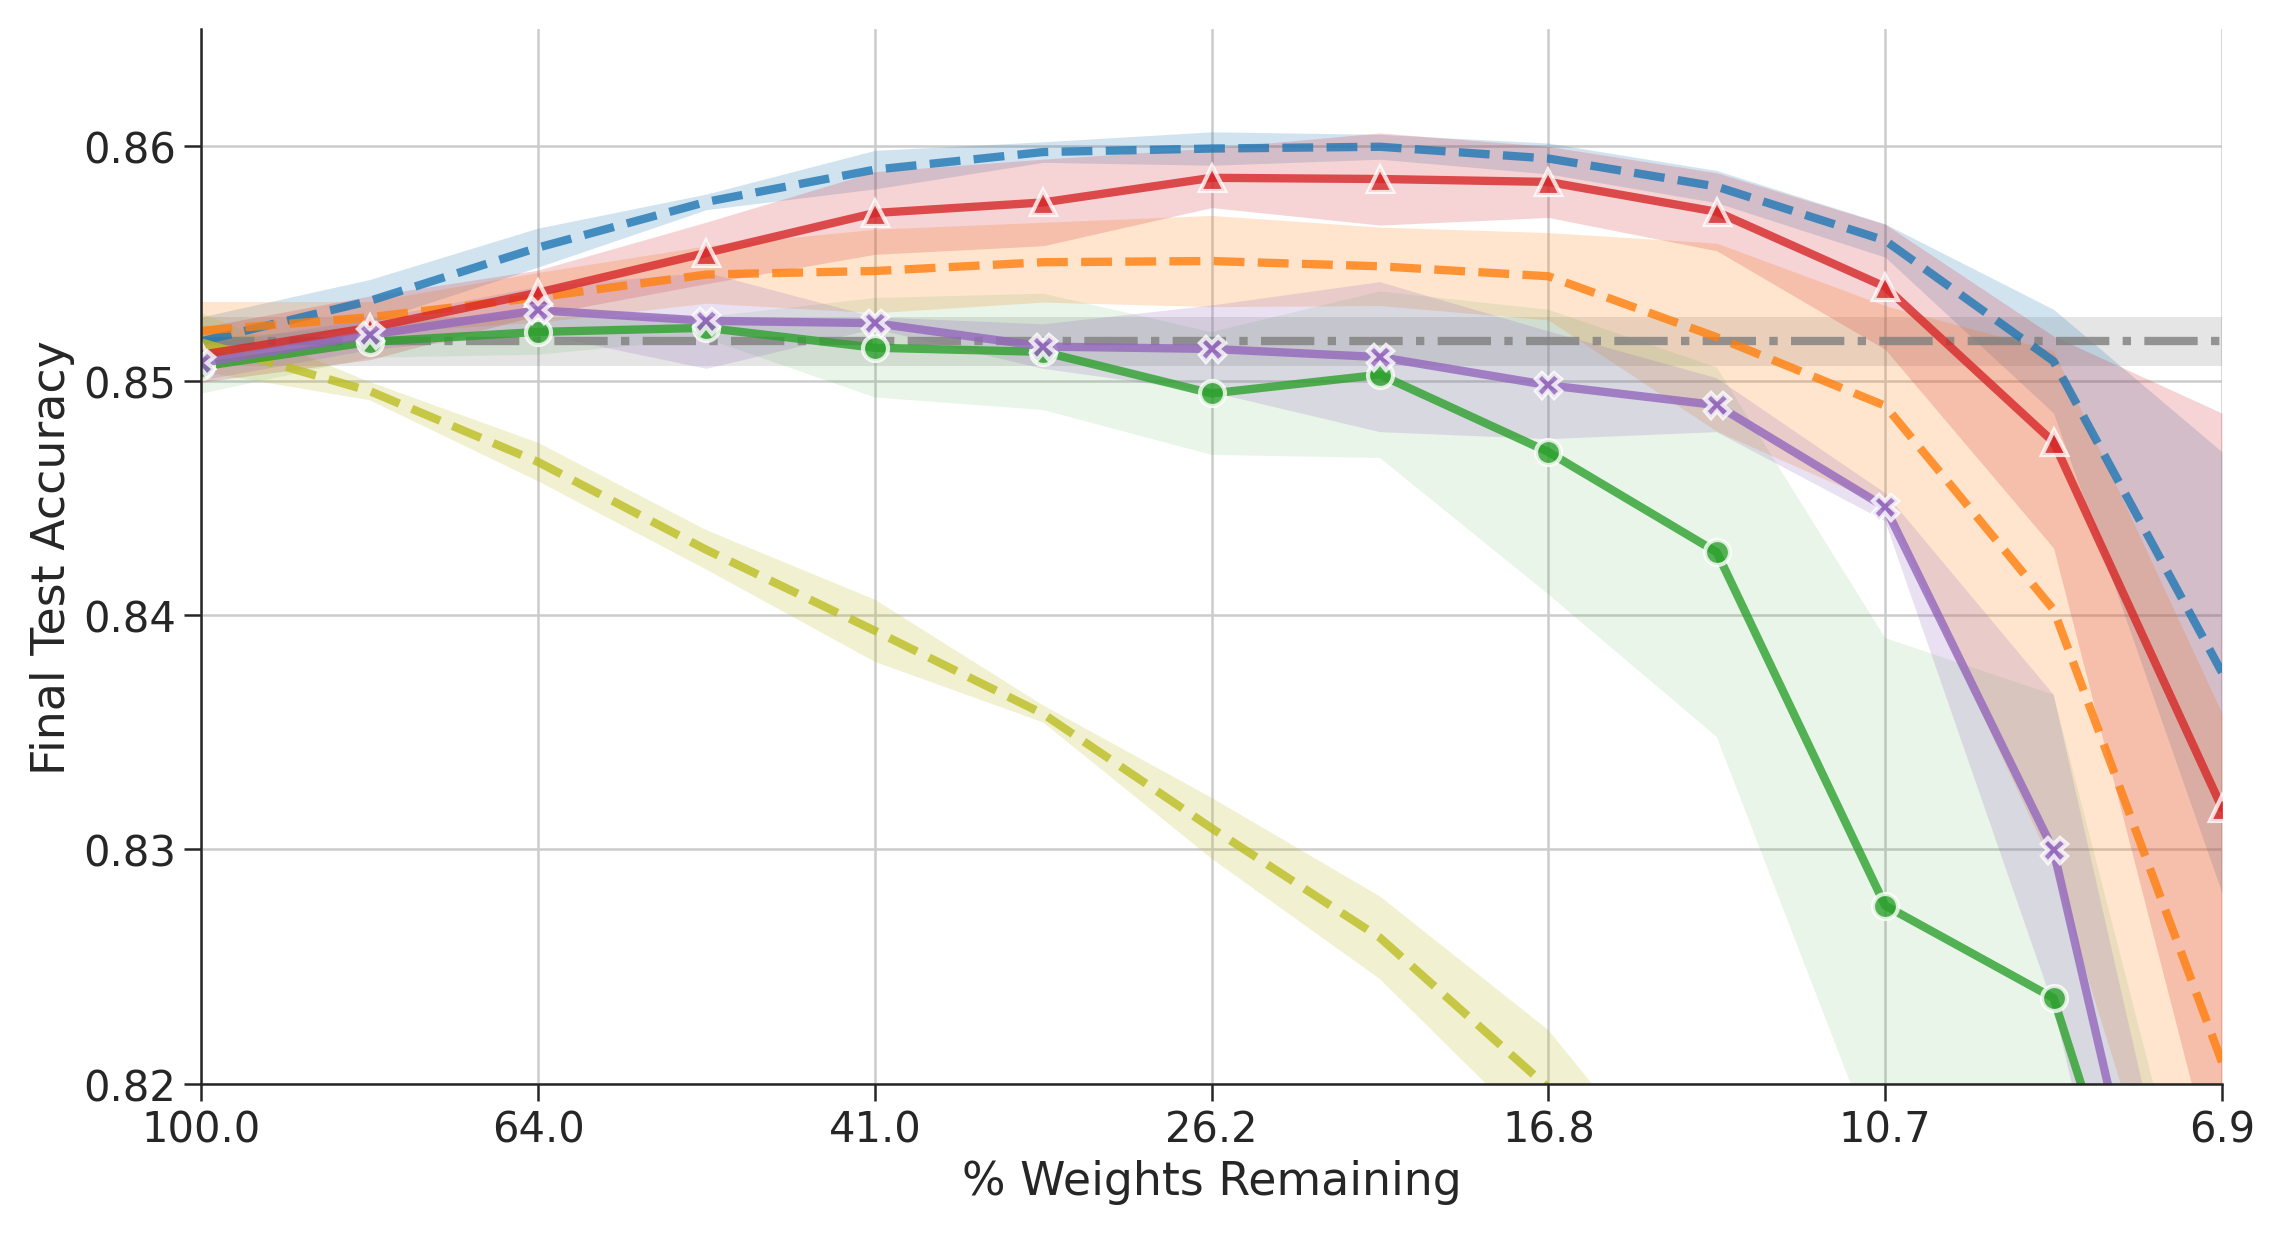

0.851675
[0.850125 0.851325 0.851875 0.8528   0.851825 0.85175  0.850975 0.85025
 0.8477   0.843225 0.83295  0.813225 0.797875]


<Figure size 600x450 with 0 Axes>

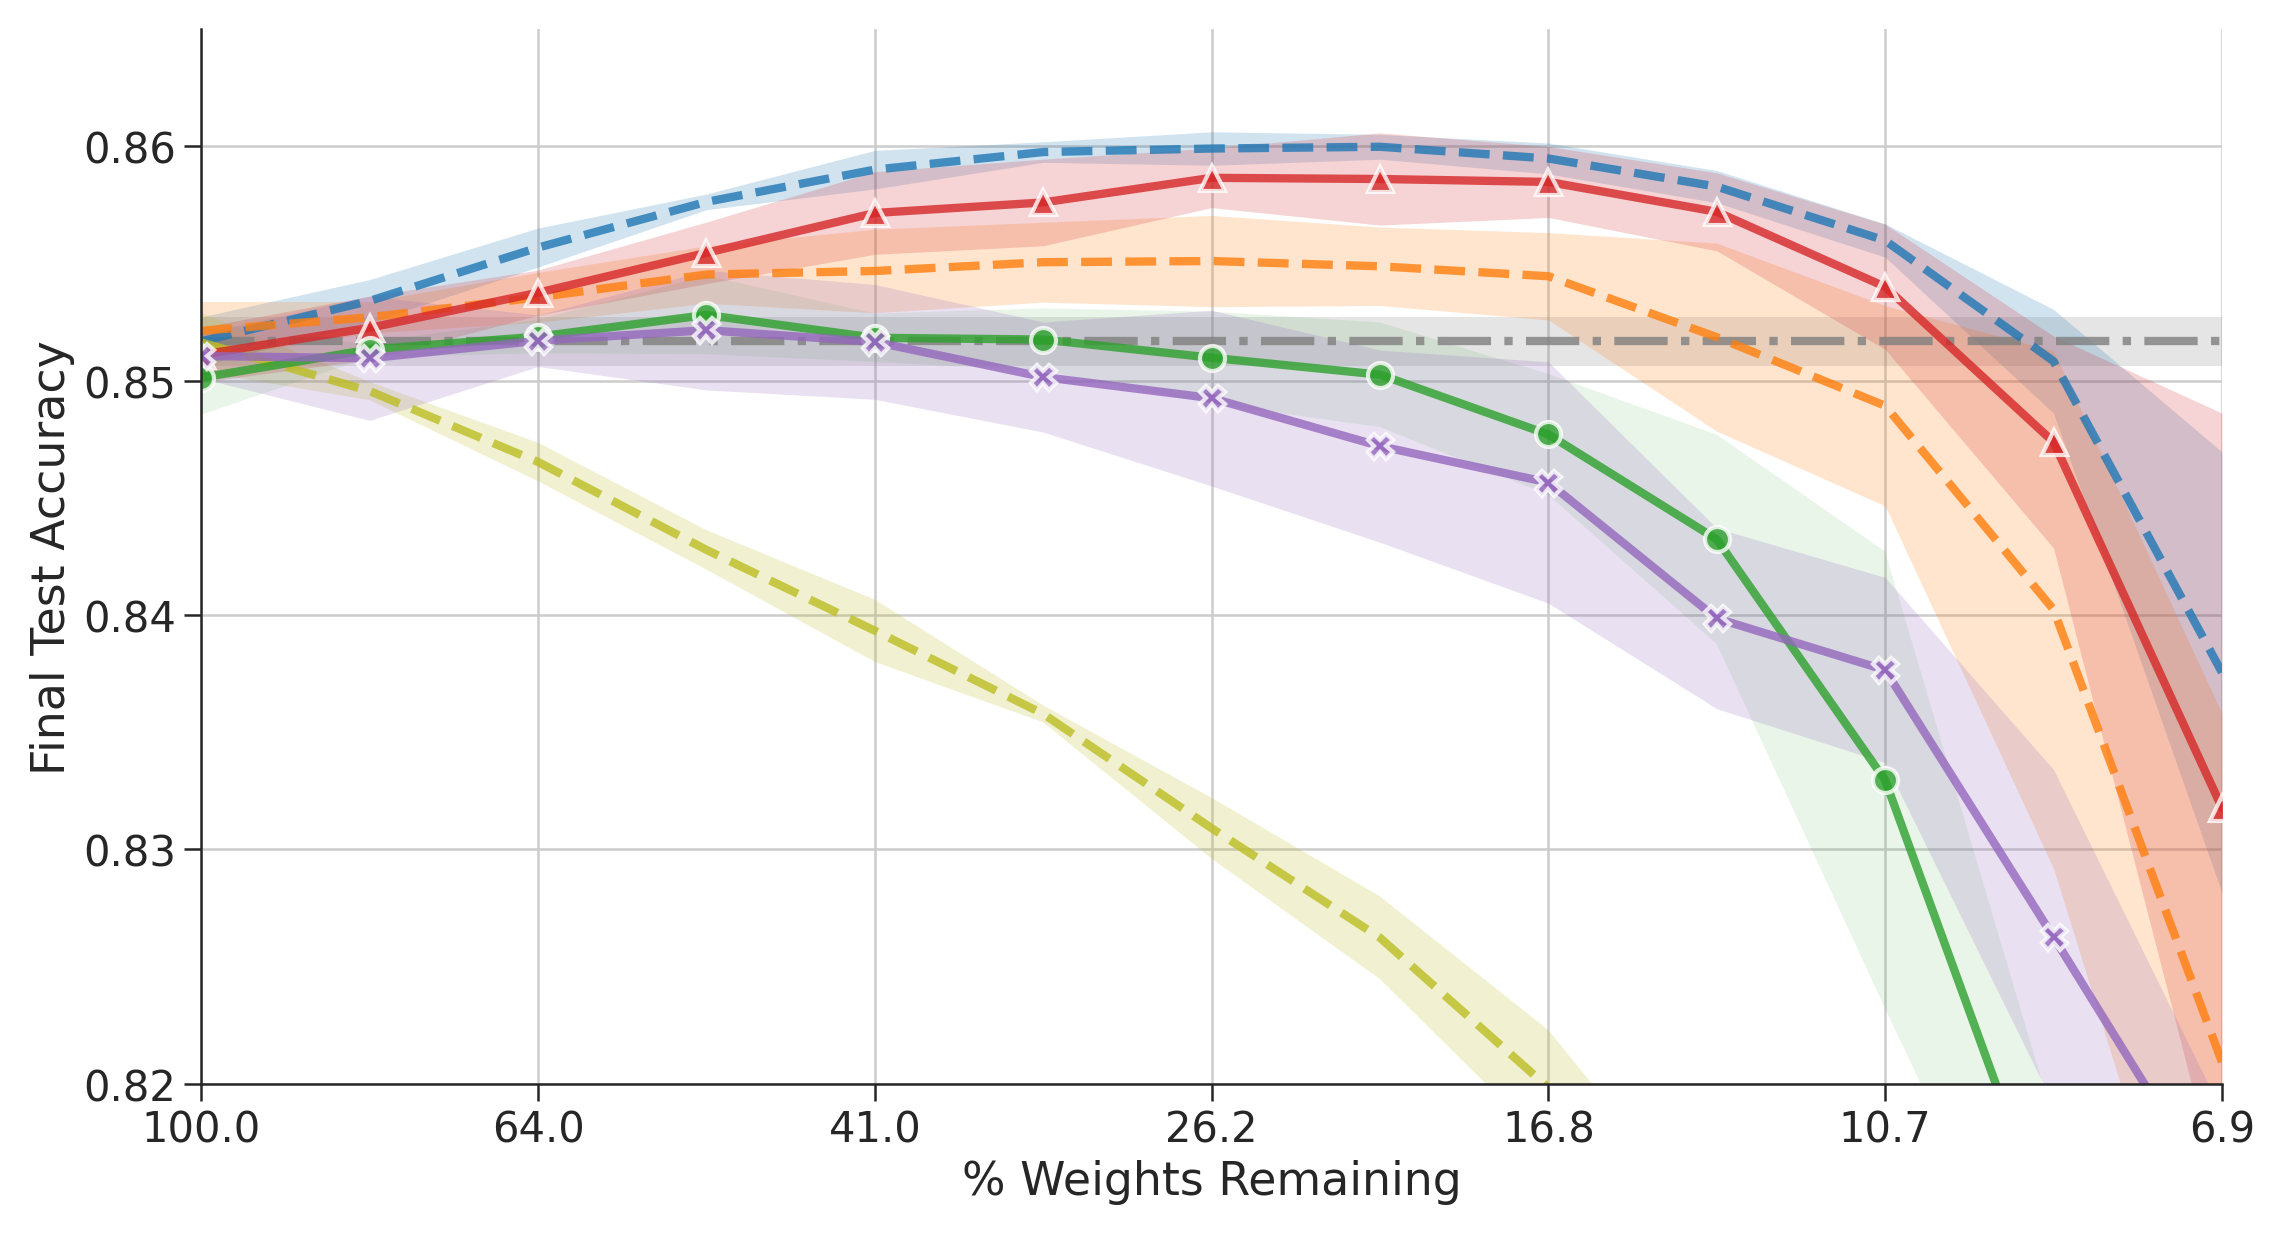

0.851675
[0.850625 0.852075 0.8527   0.8524   0.853675 0.853925 0.85415  0.853475
 0.851775 0.851175 0.8356   0.8263   0.8082  ]


<Figure size 600x450 with 0 Axes>

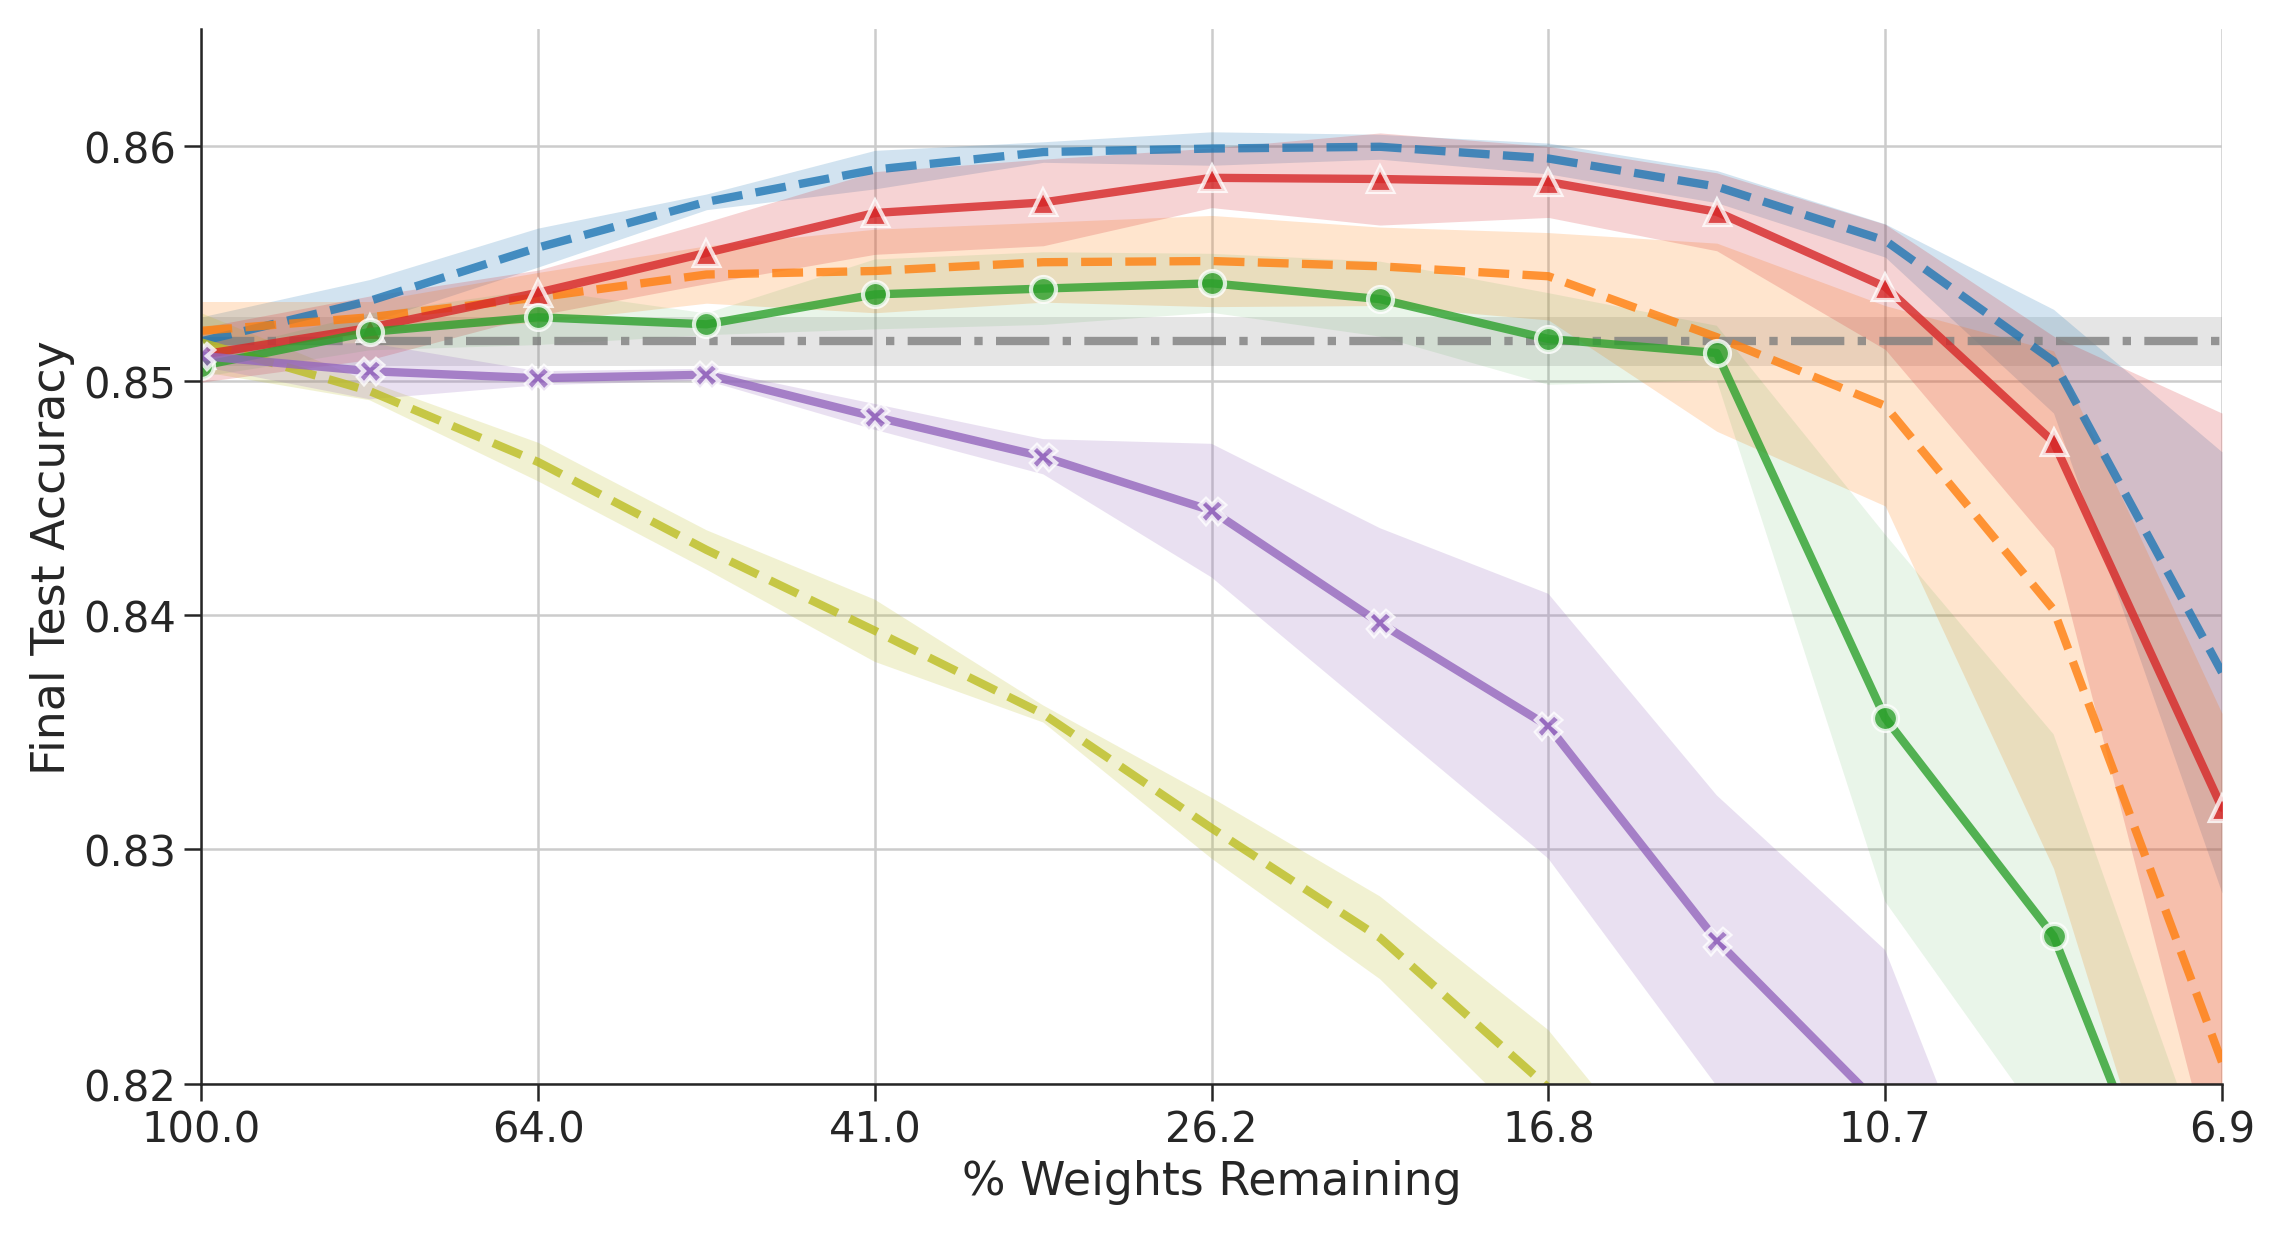

<Figure size 600x450 with 0 Axes>

In [86]:

for i in [0, 1, 2]:
    plt.figure(figsize=(7.5, 4))
    ls = []

    # Plot accuracy at level 0
    x = [0, 12]
    ys = np.transpose(accs_baseline[2, 0, :])
    y_mean, y_std = ys.mean(-1), ys.std(-1)
    print(y_mean)
    c='C7'
    l = plt.axhline(y_mean, c=c, ls='-.', alpha=0.8, linewidth=2)
    plt.fill_between(x, [y_mean + y_std]*2, [y_mean - y_std]*2, color=c, alpha=0.2)
    # ls.append(l)

    # Baseline 400
    x = np.arange(13)
    ys = np.transpose(accs_baseline[2, :, :])
    y_mean, y_std = ys.mean(0), ys.std(0)
    c = f'C0'
    l = plt.plot(x, y_mean, c=c, ls='--', alpha=0.8, linewidth=2)
    ls.append(l[0])
    plt.fill_between(x, y_mean + y_std, y_mean - y_std, color=c, alpha=0.2)

    # Baseline 200
    x = np.arange(13)
    ys = np.transpose(accs_baseline[1, :, :])
    y_mean, y_std = ys.mean(0), ys.std(0)
    c = f'C1'
    l = plt.plot(x, y_mean, c=c, ls='--', alpha=0.8, linewidth=2)
    ls.append(l[0])
    plt.fill_between(x, y_mean + y_std, y_mean - y_std, color=c, alpha=0.2)

    # Baseline 0
    x = np.arange(13)
    ys = np.transpose(accs_baseline[0, :, :])
    y_mean, y_std = ys.mean(0), ys.std(0)
    c = f'C8'
    l = plt.plot(x, y_mean, c=c, ls='--', alpha=0.8, linewidth=2)
    ls.append(l[0])
    plt.fill_between(x, y_mean + y_std, y_mean - y_std, color=c, alpha=0.2)

    # Easy data
    x = np.arange(13)
    ys = np.transpose(accs_easy[subset_idx, :, :])
    y_mean, y_std = ys.mean(0), ys.std(0)
    c = f'C3'
    l = plt.plot(x, y_mean, c=c, marker='^', alpha=0.8, linewidth=2)
    ls.append(l[0])
    plt.fill_between(x, y_mean + y_std, y_mean - y_std, color=c, alpha=0.2)

    # Random data
    x = np.arange(13)
    ys = np.transpose(accs_random[i, :, :])
    y_mean, y_std = ys.mean(0), ys.std(0)
    print(y_mean)
    c = f'C2'
    l = plt.plot(x, y_mean, c=c, marker='o', alpha=0.8, linewidth=2)
    ls.append(l[0])
    plt.fill_between(x, y_mean + y_std, y_mean - y_std, color=c, alpha=0.1)

    # Hard data
    x = np.arange(13)
    ys = np.transpose(accs_hard[i, :, :])
    y_mean, y_std = ys.mean(0), ys.std(0)
    c = f'C4'
    l = plt.plot(x, y_mean, c=c, alpha=0.8, linewidth=2, marker='X')
    ls.append(l[0])
    plt.fill_between(x, y_mean + y_std, y_mean - y_std, color=c, alpha=0.2)

    plt.xlim(0, 12)
    plt.ylim(0.82, 0.865)
    plt.xticks(np.arange(0, 13, 2), [f'{f*100:.1f}' for f in 0.8**np.arange(0, 13, 2)])
    plt.xlabel('% Weights Remaining')
    plt.ylabel('Final Test Accuracy')
    # plt.title('CIFAR100 ResNet32')
    sns.despine()
    plt.show()
    plt.savefig(f'/home/brettlarsen/lth_diet/ipynbs/figs/cinic10_rewind200_size_{subset_sizes[i]}.svg', bbox_inches='tight')

Text(0.5, 1.0, 'CINIC-10 ResNet-56')

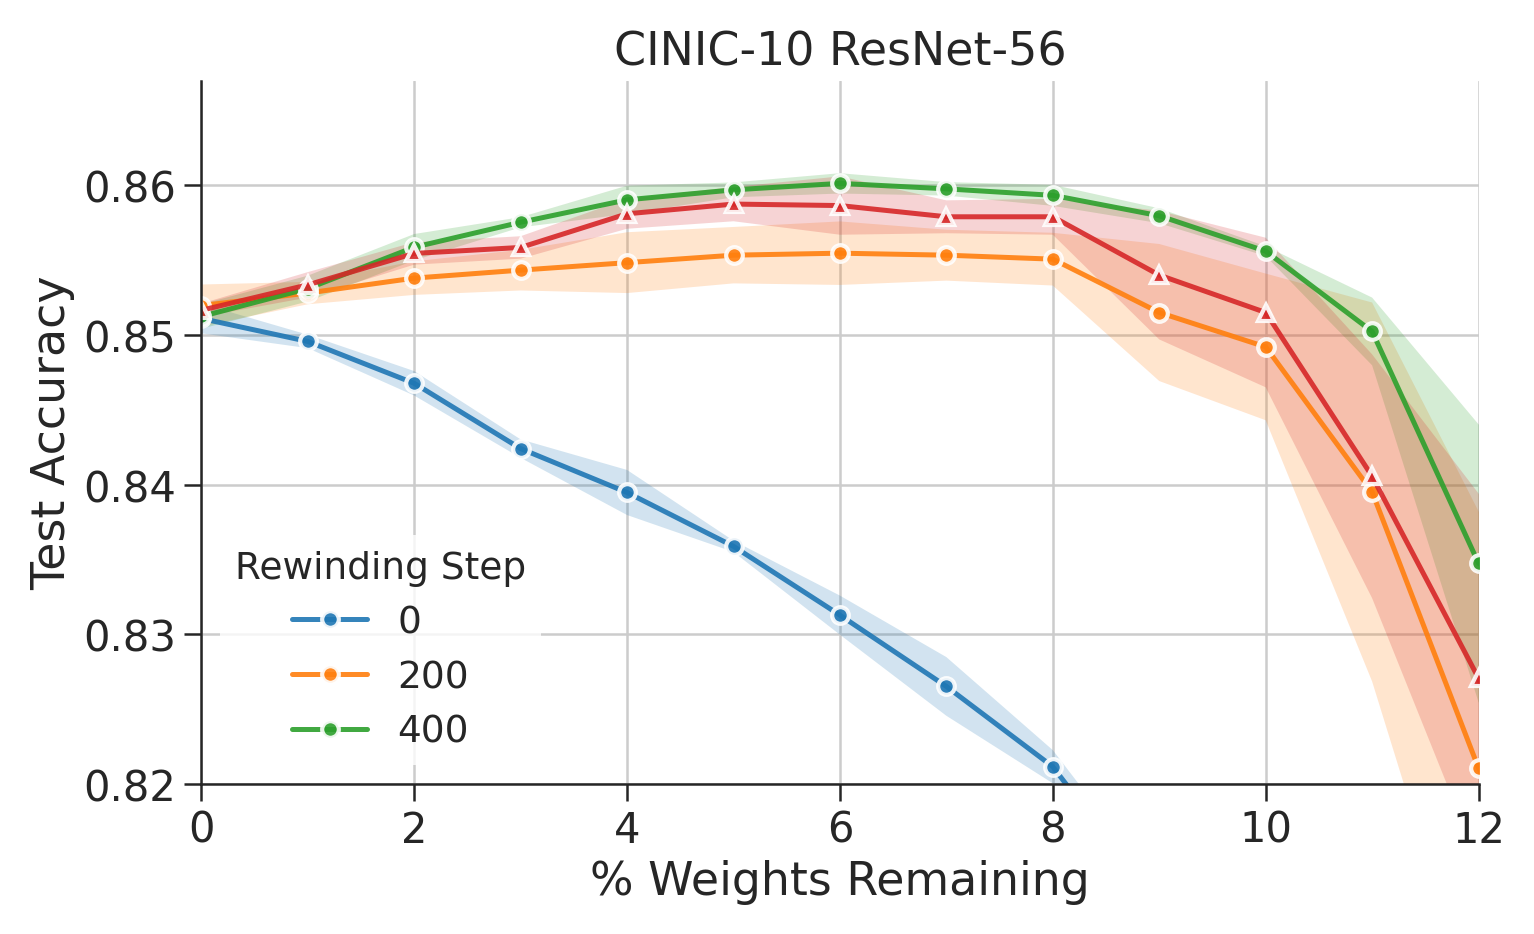

In [100]:
fig, axes = plt.subplots(dpi=150, figsize=(5, 3))
ls = []
ax = axes
x, ys = np.array(range(num_levels+1)), accs[0]
ym, ye = ys.mean(-1), ys.std(-1)
for i in [0, 1, 2]:
    ax.plot(x, ym[i], marker='o', alpha=0.9, label=rewinding_steps[i][:-2], ms=4)
    ax.fill_between(x, ym[i]-ye[i], ym[i]+ye[i], alpha=0.2)
x, ys = np.array(range(num_levels+1)), accs_easy[:, 0, :, :]
ym, ye = ys.mean(-1), ys.std(-1)
for i in range(2,3):
    ax.plot(x, ym[i], marker='^', alpha=0.9, ms=4)
    ax.fill_between(x, ym[i]-ye[i], ym[i]+ye[i], alpha=0.2)
ax.legend(fontsize=9, title="Rewinding Step", title_fontsize=9)
ax.set_ylim(0.82, 0.867)
ax.set_xlim(0, 12)
#ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14], ['100.0', '64.0', '41.0', '26.2', '16.8', '10.7', '6.9', '4.4'])
ax.set_ylabel("Test Accuracy")
ax.set_xlabel("% Weights Remaining")
ax.set_title("CINIC-10 ResNet-56")

In [40]:
x, ys = np.array(range(num_levels+1)), accs_easy
ym, ye = ys.mean(-1), ys.std(-1)

print(ym)

[[0.84953333 0.85193333 0.85326667 0.8553     0.85623333 0.85653333
  0.8565     0.8569     0.85603333 0.85563333 0.85123333 0.83286667
  0.82043333 0.81016667 0.79096667 0.7771     0.76486667]
 [0.8478     0.85093333 0.8532     0.8547     0.85516667 0.8559
  0.85683333 0.8569     0.85606667 0.85406667 0.85166667 0.8365
  0.82363333 0.79896667 0.7839     0.7701     0.7576    ]]


In [ ]:
fig, axes = plt.subplots(dpi=150)
ls = []
ax = axes
x, ys = np.array(range(num_levels+1)), accs_slr[0]
ym, ye = ys.mean(-1), ys.std(-1)
ax.plot(x, ym, marker='s', alpha=0.95, label=rewinding_steps[0][:-2])
ax.fill_between(x, ym-ye, ym+ye, alpha=0.2)
x, ys = np.array(range(num_levels+1)), accs_slr[2]
ym, ye = ys.mean(-1), ys.std(-1)
ax.plot(x, ym, marker='^', alpha=0.95, label=rewinding_steps[2][:-2])
ax.fill_between(x, ym-ye, ym+ye, alpha=0.2)
x, ys = np.array(range(num_levels+1)), accs_slr[4]
ym, ye = ys.mean(-1), ys.std(-1)
ax.plot(x, ym, marker='o', alpha=0.95, label=rewinding_steps[4][:-2])
ax.fill_between(x, ym-ye, ym+ye, alpha=0.2)
ax.legend(fontsize=9, title="Rewind Step", title_fontsize=9)
ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14], ['100', '64', '41', '26', '17', '11', '7', '4'])
ax.set_ylabel("Test Accuracy")
ax.set_xlabel("% Weights Remaining")
ax.set_title("CIFAR10 ResNet20")

In [ ]:
1 - accs_slr[4].mean(-1)